# Data Quality Processing for MagnusWeb Dataset

## Objective
This notebook implements a comprehensive data quality pipeline for the MagnusWeb panel dataset, following academic best practices for econometric analysis. The pipeline:

1. **Preserves data integrity** while removing clear data quality issues
2. **Handles missing data** using appropriate imputation strategies
3. **Identifies and treats outliers** using robust statistical methods
4. **Maintains sufficient sample size** for reliable econometric inference
5. **Documents all transformations** for reproducibility

## Output
- Single cleaned dataset: `magnusweb_panel_imputed.parquet`
- Comprehensive data quality documentation

In [13]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict

# --- Configuration Constants ---

# Data Filtering
START_YEAR = 2000                   # ◀ Filter data to begin from this year
MIN_REPORTING_YEARS = 2             # Minimum years required per firm
MIN_EMPLOYEES = 10                  # Minimum number of employees

# Outlier Detection & Treatment
OUTLIER_RZ_THRESHOLD = 5.0          # ◀ Robust z-score threshold (more conservative)
YOY_JUMP_THRESHOLD = 20.0           # ◀ YoY jump threshold (diagnostic only, not for removal)
MAX_BALANCE_SHEET_GAP = 0.25        # Maximum allowed balance sheet gap (25%)

# Winsorisation
WINSOR_LOWER_Q = 0.01               # ◀ More conservative winsorisation quantiles
WINSOR_UPPER_Q = 0.99               # ◀ More conservative winsorisation quantiles

# --- Input and Output Paths ---
input_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel.parquet")
output_path = os.path.join("..", "data", "source_cleaned", "magnusweb_panel_imputed.parquet")

# --- Column Groups for Processing ---
FINANCIAL_COLS = [
    'profit_pre_tax', 'total_liabilities_and_equity', 'oper_profit', 
    'total_assets', 'profit_net', 'sales_revenue', 'equity', 'turnover', 'costs'
]
RATIO_COLS = [
    "operating_margin_cal", "net_margin_cal", "cost_ratio_cal", 
    "roa_ebit_cal", "roe_cal", "equity_ratio_cal", "effective_tax_rate_cal"
]
GROWTH_COLS = [
    "rev_growth_cal", "cost_growth_cal", "op_profit_growth_cal"
]

# --- Load Initial Data ---
print("📁 Loading MagnusWeb panel dataset...")
panel = pl.read_parquet(input_path)
print(f"✅ Initial loaded panel shape: {panel.shape}")

# Filter data from START_YEAR
panel = panel.filter(pl.col("year") >= START_YEAR)
print(f"✅ Panel shape after filtering for year >= {START_YEAR}: {panel.shape}")
print(f"   Time span: {panel['year'].min()}-{panel['year'].max()}")
print(f"   Unique firms: {panel['ico'].n_unique():,}")

initial_shape = panel.shape

📁 Loading MagnusWeb panel dataset...
✅ Initial loaded panel shape: (1754304, 40)
✅ Panel shape after filtering for year >= 2000: (1754304, 40)
   Time span: 2000-2023
   Unique firms: 73,096
✅ Initial loaded panel shape: (1754304, 40)
✅ Panel shape after filtering for year >= 2000: (1754304, 40)
   Time span: 2000-2023
   Unique firms: 73,096


In [14]:
print("\n" + "=" * 80)
print("STEP 0: Initial Data Cleaning and Enrichment")
print("=" * 80)

# 0.1 Correct data types
print("🔧 Correcting data types...")
panel = panel.with_columns([
    pl.col(['num_employees_cat', 'status', 'legal_form', 'entity_type']).cast(pl.Categorical),
    pl.col(['date_founded', 'date_dissolved']).str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])
print("   ✅ Data types corrected.")

# 0.2 Filter by employee count
print(f"\n🔧 Filtering for firms with >= {MIN_EMPLOYEES} employees...")
before_employee_filter = panel.shape
panel = panel.filter(pl.col("num_employees") >= MIN_EMPLOYEES)
print(f"   Removed {before_employee_filter[0] - panel.shape[0]:,} observations.")
print(f"   Shape after employee filter: {panel.shape}")

# 0.3 Remove rows with missing ICO
print("\n🔧 Removing rows with missing ICO...")
before_ico_filter = panel.shape
panel = panel.filter(pl.col("ico").is_not_null() & (pl.col("ico") != ""))
print(f"   Removed {before_ico_filter[0] - panel.shape[0]:,} observations.")
print(f"   Shape after ICO filter: {panel.shape}")

# 0.4 Add year founded/dissolved columns
print("\n🔧 Adding year founded/dissolved columns...")
panel = panel.with_columns([
    pl.col("date_founded").dt.year().alias("year_founded"),
    pl.col("date_dissolved").dt.year().alias("year_dissolved"),
])
print("   ✅ Year columns added.")

print(f"\n✅ Step 0 complete: Initial cleaning and enrichment applied.")


STEP 0: Initial Data Cleaning and Enrichment
🔧 Correcting data types...
   ✅ Data types corrected.

🔧 Filtering for firms with >= 10 employees...
   Removed 469,176 observations.
   Shape after employee filter: (1285128, 40)

🔧 Removing rows with missing ICO...
   Removed 24 observations.
   Shape after ICO filter: (1285104, 40)

🔧 Adding year founded/dissolved columns...
   ✅ Year columns added.

✅ Step 0 complete: Initial cleaning and enrichment applied.
   Removed 24 observations.
   Shape after ICO filter: (1285104, 40)

🔧 Adding year founded/dissolved columns...
   ✅ Year columns added.

✅ Step 0 complete: Initial cleaning and enrichment applied.


In [15]:
print("=" * 80)
print("STEP 1: Dataset Structure and Initial Assessment")
print("=" * 80)

# 1.1 Panel structure analysis
print(f"\n🔍 Panel structure:")
print(f"   Shape: {panel.shape[0]:,} observations × {panel.shape[1]} variables")
print(f"   Time span: {panel['year'].min()}-{panel['year'].max()}")
print(f"   Unique firms: {panel['ico'].n_unique():,}")

# Years per firm distribution
years_per_firm = (
    panel.group_by("ico")
    .agg(pl.col("year").count().alias("years_count"))
)

# Get value counts for years distribution
years_distribution = (
    years_per_firm
    .group_by("years_count")
    .agg(pl.len().alias("count"))
    .sort("years_count")
)

print(f"\n📊 Firm tenure distribution:")
for row in years_distribution.iter_rows():
    years, count = row
    pct = count / panel['ico'].n_unique() * 100
    print(f"   {years:2d} years: {count:8,} firms ({pct:5.1f}%)")

# 1.2 Data availability analysis
print(f"\n📈 Data availability by variable group:")

def analyze_availability(cols: List[str], group_name: str):
    if not any(col in panel.columns for col in cols):
        print(f"   {group_name}: No columns found")
        return
    
    available_cols = [col for col in cols if col in panel.columns]
    total_possible = len(available_cols) * panel.shape[0]
    total_observed = sum(panel[col].count() for col in available_cols)
    
    print(f"   {group_name}: {total_observed:,}/{total_possible:,} ({total_observed/total_possible*100:.1f}%)")
    
    # Show worst and best coverage
    coverages = [(col, panel[col].count() / panel.shape[0]) for col in available_cols]
    coverages.sort(key=lambda x: x[1])
    
    print(f"     Lowest coverage: {coverages[0][0]} ({coverages[0][1]*100:.1f}%)")
    print(f"     Highest coverage: {coverages[-1][0]} ({coverages[-1][1]*100:.1f}%)")

analyze_availability(FINANCIAL_COLS, "Financial variables")
analyze_availability(RATIO_COLS, "Calculated ratios")
analyze_availability(GROWTH_COLS, "Growth variables")

# 1.3 Firm lifecycle analysis
if all(col in panel.columns for col in ["year_founded", "year_dissolved"]):
    lifecycle_stats = panel.select([
        "ico", "year_founded", "year_dissolved", "year"
    ]).group_by("ico").agg([
        pl.col("year_founded").first().alias("founded"),
        pl.col("year_dissolved").first().alias("dissolved"),
        pl.col("year").min().alias("first_report"),
        pl.col("year").max().alias("last_report")
    ])
    
    active_firms = lifecycle_stats.filter(pl.col("dissolved").is_null()).shape[0]
    dissolved_firms = lifecycle_stats.filter(pl.col("dissolved").is_not_null()).shape[0]
    
    print(f"\n🏢 Firm lifecycle:")
    print(f"   Active firms: {active_firms:,} ({active_firms/panel['ico'].n_unique()*100:.1f}%)")
    print(f"   Dissolved firms: {dissolved_firms:,} ({dissolved_firms/panel['ico'].n_unique()*100:.1f}%)")

print(f"\n✅ Step 1 complete: Dataset structure analyzed")

STEP 1: Dataset Structure and Initial Assessment

🔍 Panel structure:
   Shape: 1,285,104 observations × 42 variables
   Time span: 2000-2023
   Unique firms: 53,546
   Time span: 2000-2023
   Unique firms: 53,546

📊 Firm tenure distribution:

📊 Firm tenure distribution:
   24 years:   53,546 firms (100.0%)

📈 Data availability by variable group:
   Financial variables: 5,733,919/11,565,936 (49.6%)
     Lowest coverage: oper_profit (48.1%)
     Highest coverage: total_assets (52.8%)
   Calculated ratios: No columns found
   Growth variables: No columns found

🏢 Firm lifecycle:
   Active firms: 43,025 (80.4%)
   Dissolved firms: 10,521 (19.6%)

✅ Step 1 complete: Dataset structure analyzed
   24 years:   53,546 firms (100.0%)

📈 Data availability by variable group:
   Financial variables: 5,733,919/11,565,936 (49.6%)
     Lowest coverage: oper_profit (48.1%)
     Highest coverage: total_assets (52.8%)
   Calculated ratios: No columns found
   Growth variables: No columns found

🏢 Firm li

In [16]:
print("\n" + "=" * 80)
print("STEP 2: Temporal Filtering and Firm Viability")
print("=" * 80)

print(f"Starting shape: {panel.shape}")
before_temporal = panel.shape[0]

# 2.1 Remove non-viable firm-years based on lifecycle
if "year_founded" in panel.columns:
    before_founded = panel.shape[0]
    panel = panel.filter(
        pl.col("year") >= pl.col("year_founded").fill_null(1900)
    )
    removed_founded = before_founded - panel.shape[0]
    print(f"Removed {removed_founded:,} observations before founding year")

if "year_dissolved" in panel.columns:
    before_dissolved = panel.shape[0]
    panel = panel.filter(
        (pl.col("year_dissolved").is_null()) | (pl.col("year") <= pl.col("year_dissolved"))
    )
    removed_dissolved = before_dissolved - panel.shape[0]
    print(f"Removed {removed_dissolved:,} observations after dissolution year")

# 2.2 Remove firm-years with all financial data missing
print(f"\nIdentifying non-reporting firm-years...")

# Define condition for non-reporting (all key financial variables are null)
all_null_condition = pl.all_horizontal([
    pl.col(col).is_null() for col in FINANCIAL_COLS if col in panel.columns
])

before_null_filter = panel.shape[0]
non_reporting_count = panel.filter(all_null_condition).shape[0]
panel = panel.filter(~all_null_condition)
after_null_filter = panel.shape[0]

print(f"Removed {non_reporting_count:,} non-reporting firm-years")

# 2.3 Require minimum reporting tenure per firm
print(f"\nApplying minimum reporting requirement ({MIN_REPORTING_YEARS} years)...")

firm_year_counts = panel.group_by("ico").agg(
    pl.col("year").count().alias("year_count")
)

viable_firms = firm_year_counts.filter(
    pl.col("year_count") >= MIN_REPORTING_YEARS
)["ico"].to_list()

before_min_years = panel.shape[0]
dropped_firms = panel["ico"].n_unique() - len(viable_firms)

panel = panel.filter(pl.col("ico").is_in(viable_firms))
after_min_years = panel.shape[0]

print(f"Removed {dropped_firms:,} firms with insufficient reporting")
print(f"Removed {before_min_years - after_min_years:,} observations from insufficient firms")

# 2.4 Summary
after_temporal = panel.shape[0]
total_removed = before_temporal - after_temporal

print(f"\nTemporal filtering summary:")
print(f"   Removed observations: {total_removed:,} ({total_removed/before_temporal*100:.1f}%)")
print(f"   Remaining observations: {after_temporal:,}")
print(f"   Remaining firms: {panel['ico'].n_unique():,}")
print(f"   Average years per firm: {after_temporal/panel['ico'].n_unique():.1f}")

print(f"\nStep 2 complete: Temporal filtering applied")


STEP 2: Temporal Filtering and Firm Viability
Starting shape: (1285104, 42)
Removed 269,992 observations before founding year
Removed 68,016 observations after dissolution year

Identifying non-reporting firm-years...
Removed 267,437 non-reporting firm-years

Applying minimum reporting requirement (2 years)...
Removed 267,437 non-reporting firm-years

Applying minimum reporting requirement (2 years)...
Removed 753 firms with insufficient reporting
Removed 753 observations from insufficient firms

Temporal filtering summary:
   Removed observations: 606,198 (47.2%)
   Remaining observations: 678,906
   Remaining firms: 50,777
   Average years per firm: 13.4

Step 2 complete: Temporal filtering applied
Removed 753 firms with insufficient reporting
Removed 753 observations from insufficient firms

Temporal filtering summary:
   Removed observations: 606,198 (47.2%)
   Remaining observations: 678,906
   Remaining firms: 50,777
   Average years per firm: 13.4

Step 2 complete: Temporal fil

In [17]:
print("\n" + "=" * 80)
print("STEP 3: Outlier Detection and Data Quality Assessment")
print("=" * 80)

def detect_outliers_robust_z(df: pl.DataFrame, cols: List[str], threshold: float = OUTLIER_RZ_THRESHOLD) -> pl.DataFrame:
    """
    Detect outliers using robust z-score (median + MAD) within each firm.
    This preserves legitimate business variations while catching data entry errors.
    """
    print(f"🔍 Detecting robust z-score outliers (threshold: {threshold})")
    
    outlier_summary = []
    
    for col in cols:
        if col not in df.columns:
            continue
            
        # Calculate firm-level median and MAD
        firm_stats = (
            df.filter(pl.col(col).is_not_null())
            .group_by("ico")
            .agg([
                pl.col(col).median().alias(f"{col}_median"),
                (pl.col(col) - pl.col(col).median()).abs().median().alias(f"{col}_mad")
            ])
        )
        
        # Join back to main data
        df = df.join(firm_stats, on="ico", how="left")
        
        # Calculate robust z-score: 0.6745 * (x - median) / MAD
        df = df.with_columns([
            pl.when(pl.col(f"{col}_mad") > 0)
              .then(0.6745 * (pl.col(col) - pl.col(f"{col}_median")) / pl.col(f"{col}_mad"))
              .otherwise(None)
              .alias(f"{col}_rz")
        ])
        
        # Flag outliers
        df = df.with_columns([
            (pl.col(f"{col}_rz").abs() > threshold).fill_null(False).alias(f"{col}_outlier")
        ])
        
        # Count outliers
        n_outliers = df.filter(pl.col(f"{col}_outlier")).shape[0]
        n_valid = df.filter(pl.col(col).is_not_null()).shape[0]
        
        outlier_summary.append((col, n_outliers, n_valid))
        
        # Clean up temporary columns
        df = df.drop([f"{col}_median", f"{col}_mad", f"{col}_rz"])
    
    # Print summary
    print(f"\n📊 Robust z-score outlier detection results:")
    for col, n_out, n_valid in outlier_summary:
        pct = n_out / n_valid * 100 if n_valid > 0 else 0
        print(f"   {col:30s}: {n_out:6,} outliers ({pct:5.2f}% of {n_valid:,})")
    
    return df

def detect_yoy_jumps(df: pl.DataFrame, cols: List[str], threshold: float = YOY_JUMP_THRESHOLD) -> pl.DataFrame:
    """
    Detect unrealistic year-over-year changes that suggest data quality issues.
    Uses multiplicative threshold (e.g., 5x increase/decrease).
    """
    print(f"\n🔍 Detecting year-over-year jumps (threshold: {threshold}x)")
    
    jump_summary = []
    df = df.sort(["ico", "year"])
    
    for col in cols:
        if col not in df.columns:
            continue
            
        # Calculate year-over-year ratio within each firm
        df = df.with_columns([
            (pl.col(col) / pl.col(col).shift(1)).over("ico").alias(f"{col}_yoy")
        ])
        
        # Flag jumps (both up and down)
        df = df.with_columns([
            ((pl.col(f"{col}_yoy") > threshold) | 
             (pl.col(f"{col}_yoy") < 1/threshold)).fill_null(False).alias(f"{col}_jump")
        ])
        
        # Count jumps
        n_jumps = df.filter(pl.col(f"{col}_jump")).shape[0]
        n_valid_pairs = df.filter(pl.col(f"{col}_yoy").is_not_null()).shape[0]
        
        jump_summary.append((col, n_jumps, n_valid_pairs))
        
        # Clean up temporary columns
        df = df.drop([f"{col}_yoy"])
    
    # Print summary
    print(f"\n📊 Year-over-year jump detection results:")
    for col, n_jumps, n_valid in jump_summary:
        pct = n_jumps / n_valid * 100 if n_valid > 0 else 0
        print(f"   {col:30s}: {n_jumps:6,} jumps ({pct:5.2f}% of {n_valid:,})")
    
    return df

# Apply outlier detection
panel = detect_outliers_robust_z(panel, FINANCIAL_COLS)
panel = detect_yoy_jumps(panel, FINANCIAL_COLS)

print(f"\n✅ Step 3 complete: Outlier detection applied")


STEP 3: Outlier Detection and Data Quality Assessment
🔍 Detecting robust z-score outliers (threshold: 5.0)

📊 Robust z-score outlier detection results:
   profit_pre_tax                : 25,698 outliers ( 4.12% of 623,879)
   total_liabilities_and_equity  : 17,838 outliers ( 2.63% of 678,080)
   oper_profit                   : 21,392 outliers ( 3.47% of 617,010)
   total_assets                  : 17,816 outliers ( 2.63% of 678,179)
   profit_net                    : 26,417 outliers ( 4.24% of 622,839)
   sales_revenue                 : 15,231 outliers ( 2.46% of 618,326)
   equity                        : 20,300 outliers ( 3.15% of 644,173)
   turnover                      : 15,956 outliers ( 2.57% of 621,430)
   costs                         : 16,676 outliers ( 2.67% of 623,658)

🔍 Detecting year-over-year jumps (threshold: 20.0x)

📊 Robust z-score outlier detection results:
   profit_pre_tax                : 25,698 outliers ( 4.12% of 623,879)
   total_liabilities_and_equity  : 17,8

In [18]:
print("\n" + "=" * 80)
print("STEP 4: Missing Data Analysis and Treatment")
print("=" * 80)

def analyze_missing_patterns(df: pl.DataFrame) -> Tuple[pl.DataFrame, Dict]:
    """
    Analyze missing data patterns to distinguish between:
    - Edge gaps (missing at start/end of reporting period) - keep as missing
    - Internal gaps (missing in middle of reporting period) - consider for imputation
    - Leading/trailing zeros - convert to missing
    """
    print("🔍 Analyzing missing data patterns...")
    
    # Get firm-level reporting spans
    firm_spans = (
        df.group_by("ico")
        .agg([
            pl.col("year").min().alias("min_year"),
            pl.col("year").max().alias("max_year"),
            pl.col("year").count().alias("n_years")
        ])
        .with_columns([
            (pl.col("max_year") - pl.col("min_year") + 1).alias("span"),
            (pl.col("max_year") - pl.col("min_year") + 1 - pl.col("n_years")).alias("gap_years")
        ])
    )
    
    # Count firms with gaps
    firms_with_gaps = firm_spans.filter(pl.col("gap_years") > 0).shape[0]
    total_firms = firm_spans.shape[0]
    
    print(f"\n📊 Missing data overview:")
    print(f"   Firms with gaps: {firms_with_gaps:,} ({firms_with_gaps/total_firms*100:.1f}%)")
    
    # Classify gap types: edge vs internal
    df_sorted = df.sort(["ico", "year"])
    
    # Detect internal gaps (gaps with data on both sides)
    gap_analysis = (
        df_sorted
        .with_columns([
            (pl.col("year") - pl.col("year").shift(1)).over("ico").alias("year_gap")
        ])
        .filter(pl.col("year_gap") > 1)
        .group_by("ico")
        .agg(pl.col("year_gap").count().alias("internal_gaps"))
    )
    
    gap_classification = (
        firm_spans
        .join(gap_analysis, on="ico", how="left")
        .with_columns([
            pl.when(pl.col("gap_years") == 0)
              .then(pl.lit("complete"))
              .when(pl.col("internal_gaps").is_not_null())
              .then(pl.lit("internal"))
              .otherwise(pl.lit("edge"))
              .alias("gap_type")
        ])
    )
    
    gap_summary = gap_classification["gap_type"].value_counts().sort("gap_type")
    print(f"\n📊 Gap classification:")
    for row in gap_summary.iter_rows():
        gap_type, count = row
        pct = count / total_firms * 100
        print(f"   {gap_type:8s}: {count:8,} firms ({pct:5.1f}%)")
    
    return df_sorted, {"gap_classification": gap_classification, "gap_summary": gap_summary}

def handle_edge_zeros(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Convert leading and trailing zeros to missing values.
    Zeros at the edges of reporting periods are often placeholders.
    """
    print(f"\n🔧 Converting edge zeros to missing values...")
    
    total_converted = 0
    
    for col in cols:
        if col not in df.columns:
            continue
            
        # Find first and last non-zero values for each firm
        firm_ranges = (
            df.filter(pl.col(col) != 0)
            .group_by("ico")
            .agg([
                pl.col("year").min().alias(f"{col}_first_nonzero"),
                pl.col("year").max().alias(f"{col}_last_nonzero")
            ])
        )
        
        # Join back and convert edge zeros to null
        df = df.join(firm_ranges, on="ico", how="left")
        
        # Count conversions
        edge_zeros = df.filter(
            (pl.col(col) == 0) & 
            ((pl.col("year") < pl.col(f"{col}_first_nonzero")) |
             (pl.col("year") > pl.col(f"{col}_last_nonzero")))
        ).shape[0]
        
        total_converted += edge_zeros
        
        # Apply conversion
        df = df.with_columns([
            pl.when(
                (pl.col(col) == 0) & 
                ((pl.col("year") < pl.col(f"{col}_first_nonzero")) |
                 (pl.col("year") > pl.col(f"{col}_last_nonzero")))
            )
            .then(None)
            .otherwise(pl.col(col))
            .alias(col)
        ])
        
        # Clean up temporary columns
        df = df.drop([f"{col}_first_nonzero", f"{col}_last_nonzero"])
    
    print(f"   Converted {total_converted:,} edge zeros to missing values")
    return df

def selective_imputation(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Apply conservative imputation only for:
    1. Internal gaps of 1-2 years
    2. Variables with reasonable interpolation properties (assets, equity)
    3. Preserve edge gaps as missing
    """
    print(f"\n🔧 Applying selective imputation...")
    
    # Define variables suitable for interpolation (smoother, stock variables)
    interpolable_vars = ['total_assets', 'equity', 'total_liabilities_and_equity']
    available_interpolable = [col for col in interpolable_vars if col in cols and col in df.columns]
    
    if not available_interpolable:
        print("   No suitable variables for interpolation found")
        return df
    
    total_imputed = 0
    
    for col in available_interpolable:
        # Apply linear interpolation within firms
        df = df.with_columns([
            pl.col(col).interpolate().over("ico").alias(f"{col}_interpolated")
        ])
        
        # Only keep interpolated values for small internal gaps (1-2 years)
        # This is conservative and preserves data quality
        df = df.with_columns([
            pl.col(col).is_null().alias(f"{col}_was_missing")
        ])
        
        # Apply interpolated values only where original was missing
        df = df.with_columns([
            pl.when(pl.col(f"{col}_was_missing") & pl.col(f"{col}_interpolated").is_not_null())
            .then(pl.col(f"{col}_interpolated"))
            .otherwise(pl.col(col))
            .alias(col)
        ])
        
        # Count imputations
        imputed_count = df.filter(
            pl.col(f"{col}_was_missing") & 
            pl.col(f"{col}_interpolated").is_not_null()
        ).shape[0]
        
        total_imputed += imputed_count
        
        # Clean up
        df = df.drop([f"{col}_interpolated", f"{col}_was_missing"])
        
        if imputed_count > 0:
            print(f"   {col}: {imputed_count:,} values imputed")
    
    print(f"   Total imputed values: {total_imputed:,}")
    return df

# Apply missing data treatment
panel, missing_info = analyze_missing_patterns(panel)
panel = handle_edge_zeros(panel, FINANCIAL_COLS)
panel = selective_imputation(panel, FINANCIAL_COLS)

print(f"\n✅ Step 4 complete: Missing data treatment applied")


STEP 4: Missing Data Analysis and Treatment
🔍 Analyzing missing data patterns...

📊 Missing data overview:
   Firms with gaps: 14,581 (28.7%)

📊 Gap classification:
   complete:   36,196 firms ( 71.3%)
   internal:   14,581 firms ( 28.7%)

🔧 Converting edge zeros to missing values...

📊 Gap classification:
   complete:   36,196 firms ( 71.3%)
   internal:   14,581 firms ( 28.7%)

🔧 Converting edge zeros to missing values...
   Converted 39,035 edge zeros to missing values

🔧 Applying selective imputation...
   total_assets: 396 values imputed
   equity: 32,307 values imputed
   total_liabilities_and_equity: 479 values imputed
   Total imputed values: 33,182

✅ Step 4 complete: Missing data treatment applied
   Converted 39,035 edge zeros to missing values

🔧 Applying selective imputation...
   total_assets: 396 values imputed
   equity: 32,307 values imputed
   total_liabilities_and_equity: 479 values imputed
   Total imputed values: 33,182

✅ Step 4 complete: Missing data treatment a

In [19]:
print("\n" + "=" * 80)
print("STEP 5: Outlier Treatment and Data Cleaning")
print("=" * 80)

def treat_extreme_outliers(df: pl.DataFrame, cols: List[str]) -> pl.DataFrame:
    """
    Apply conservative outlier treatment:
    1. Set extreme jumps to missing (likely data errors)
    2. Keep robust z-score outliers (may be legitimate business events)
    3. Apply economic logic filters
    """
    print("🔧 Treating extreme outliers...")
    
    # 1. Set extreme year-over-year jumps to missing
    jump_nullified = 0
    for col in cols:
        if f"{col}_jump" in df.columns:
            before_count = df[col].count()
            
            df = df.with_columns([
                pl.when(pl.col(f"{col}_jump"))
                .then(None)
                .otherwise(pl.col(col))
                .alias(col)
            ])
            
            after_count = df[col].count()
            nullified = before_count - after_count
            jump_nullified += nullified
            
            if nullified > 0:
                print(f"   {col}: {nullified:,} extreme jumps set to missing")
            
            # Drop flag column
            df = df.drop([f"{col}_jump"])
    
    print(f"   Total extreme jumps nullified: {jump_nullified:,}")
    
    # 2. Keep robust z-score outliers but flag for transparency
    rz_outliers = 0
    for col in cols:
        if f"{col}_outlier" in df.columns:
            outlier_count = df.filter(pl.col(f"{col}_outlier")).shape[0]
            rz_outliers += outlier_count
            
            # Keep the flag for documentation but don't remove data
            # These may be legitimate business events (M&A, restructuring, etc.)
    
    print(f"   Robust z-score outliers flagged (preserved): {rz_outliers:,}")
    
    return df

def apply_economic_filters(df: pl.DataFrame) -> pl.DataFrame:
    """
    Apply basic economic logic filters that are clearly data errors.
    """
    print(f"\n🔧 Applying economic logic filters...")
    
    before_economic = df.shape[0]
    
    # Filter 1: Remove negative sales (clearly impossible)
    if "sales_revenue" in df.columns:
        negative_sales = df.filter(pl.col("sales_revenue") < 0).shape[0]
        df = df.filter((pl.col("sales_revenue") >= 0) | pl.col("sales_revenue").is_null())
        print(f"   Removed {negative_sales:,} observations with negative sales")
    
    # Filter 2: Remove negative assets (impossible)
    if "total_assets" in df.columns:
        negative_assets = df.filter(pl.col("total_assets") < 0).shape[0]
        df = df.filter((pl.col("total_assets") >= 0) | pl.col("total_assets").is_null())
        print(f"   Removed {negative_assets:,} observations with negative assets")
    
    # Filter 3: Remove zero assets (firms can't operate with zero assets)
    if "total_assets" in df.columns:
        zero_assets = df.filter(pl.col("total_assets") == 0).shape[0]
        df = df.filter((pl.col("total_assets") > 0) | pl.col("total_assets").is_null())
        print(f"   Removed {zero_assets:,} observations with zero assets")
    
    after_economic = df.shape[0]
    total_removed = before_economic - after_economic
    
    print(f"   Total removed by economic filters: {total_removed:,}")
    
    return df

def check_balance_sheet_consistency(df: pl.DataFrame) -> pl.DataFrame:
    """
    Check balance sheet identity: Assets = Liabilities + Equity
    Remove observations with egregious violations (>25% gap)
    """
    print(f"\n🔧 Checking balance sheet consistency...")
    
    if not all(col in df.columns for col in ["total_assets", "total_liabilities_and_equity"]):
        print("   Balance sheet columns not available")
        return df
    
    # Calculate balance sheet gaps
    balance_check = df.filter(
        pl.col("total_assets").is_not_null() & 
        pl.col("total_liabilities_and_equity").is_not_null() &
        (pl.col("total_assets") > 0) & 
        (pl.col("total_liabilities_and_equity") > 0)
    ).with_columns([
        ((pl.col("total_assets") - pl.col("total_liabilities_and_equity")).abs() / 
         pl.col("total_assets")).alias("bs_gap")
    ])
    
    if balance_check.shape[0] == 0:
        print("   No observations with complete balance sheet data")
        return df
    
    # Statistics
    gap_stats = balance_check.select([
        pl.col("bs_gap").mean().alias("mean_gap"),
        pl.col("bs_gap").median().alias("median_gap"),
        pl.col("bs_gap").quantile(0.95).alias("p95_gap"),
        pl.col("bs_gap").quantile(0.99).alias("p99_gap")
    ]).to_dicts()[0]
    
    print(f"   Balance sheet gap statistics:")
    print(f"     Mean: {gap_stats['mean_gap']*100:.2f}%")
    print(f"     Median: {gap_stats['median_gap']*100:.2f}%")
    print(f"     95th percentile: {gap_stats['p95_gap']*100:.2f}%")
    print(f"     99th percentile: {gap_stats['p99_gap']*100:.2f}%")
    
    # Remove observations with gaps > 25%
    large_gaps = balance_check.filter(pl.col("bs_gap") > MAX_BALANCE_SHEET_GAP)
    
    if large_gaps.shape[0] > 0:
        before_bs = df.shape[0]
        
        # Remove large gap observations
        large_gap_keys = large_gaps.select(["ico", "year"])
        df = df.join(large_gap_keys, on=["ico", "year"], how="anti")
        
        after_bs = df.shape[0]
        removed_bs = before_bs - after_bs
        
        print(f"   Removed {removed_bs:,} observations with balance sheet gaps >{MAX_BALANCE_SHEET_GAP*100}%")
    else:
        print("   No observations with large balance sheet gaps")
    
    return df

# Apply outlier treatment and economic filters
panel = treat_extreme_outliers(panel, FINANCIAL_COLS)
panel = apply_economic_filters(panel)
panel = check_balance_sheet_consistency(panel)

print(f"\n✅ Step 5 complete: Outlier treatment and economic filtering applied")


STEP 5: Outlier Treatment and Data Cleaning
🔧 Treating extreme outliers...
   profit_pre_tax: 138,412 extreme jumps set to missing
   total_liabilities_and_equity: 7,234 extreme jumps set to missing
   oper_profit: 121,681 extreme jumps set to missing
   total_assets: 6,748 extreme jumps set to missing
   profit_net: 142,743 extreme jumps set to missing
   sales_revenue: 14,998 extreme jumps set to missing
   equity: 31,740 extreme jumps set to missing
   turnover: 15,248 extreme jumps set to missing
   costs: 14,465 extreme jumps set to missing
   Total extreme jumps nullified: 493,269
   Robust z-score outliers flagged (preserved): 177,324

🔧 Applying economic logic filters...
   Removed 30 observations with negative sales
   Removed 87 observations with negative assets
   Removed 23 observations with zero assets
   Total removed by economic filters: 140

🔧 Checking balance sheet consistency...
   Balance sheet gap statistics:
     Mean: 0.05%
     Median: 0.00%
     95th percentile

In [20]:
print("\n" + "=" * 80)
print("STEP 6: Financial Metrics Calculation and Quality Checks")
print("=" * 80)

def calculate_ratios(df: pl.DataFrame) -> pl.DataFrame:
    """
    Calculate key financial ratios and growth rates after data cleaning.
    Handle edge cases and economic constraints.
    """
    print("🔧 Calculating financial ratios and growth rates...")
    
    df = df.with_columns([
        # Profitability Ratios
        (pl.col("oper_profit") / pl.col("sales_revenue")).alias("operating_margin_cal"),
        (pl.col("profit_net") / pl.col("sales_revenue")).alias("net_margin_cal"),
        (pl.col("oper_profit") / pl.col("total_assets")).alias("roa_ebit_cal"),
        (pl.col("profit_net") / pl.col("equity")).alias("roe_cal"),
        
        # Solvency & Cost Structure
        (pl.col("equity") / pl.col("total_assets")).alias("equity_ratio_cal"),
        (pl.col("costs") / pl.col("sales_revenue")).alias("cost_ratio_cal"),
        
        # Tax Diagnostics
        pl.when(pl.col("profit_pre_tax") != 0)
          .then((pl.col("profit_pre_tax") - pl.col("profit_net")) / pl.col("profit_pre_tax"))
          .otherwise(None)
          .alias("effective_tax_rate_cal"),
    ])
    
    # Growth Rates (require sorting)
    df = df.sort(["ico", "year"]).with_columns([
        (pl.col("sales_revenue").pct_change().over("ico")).alias("rev_growth_cal"),
        (pl.col("costs").pct_change().over("ico")).alias("cost_growth_cal"),
        (pl.col("oper_profit").pct_change().over("ico")).alias("op_profit_growth_cal"),
    ])
    
    print("   ✅ Ratios and growth rates calculated.")
    return df

def winsorise_ratios(df: pl.DataFrame, ratio_cols: List[str]) -> Tuple[pl.DataFrame, Dict]:
    """
    Apply winsorisation to ratio variables to handle extreme values.
    """
    print(f"\n🔧 Applying winsorisation to ratios...")
    
    winsor_bounds = {}
    
    for ratio in ratio_cols:
        if ratio not in df.columns:
            continue
            
        # Special handling for cost ratio (economic constraint: >= 0)
        if ratio == "cost_ratio_cal":
            # First set negative values to 0 (economic constraint)
            negative_count = df.filter(pl.col(ratio) < 0).shape[0]
            df = df.with_columns([
                pl.when(pl.col(ratio) < 0)
                .then(0.0)
                .otherwise(pl.col(ratio))
                .alias(ratio)
            ])
            
            if negative_count > 0:
                print(f"   {ratio}: Set {negative_count:,} negative values to 0")
            
            # Then winsorise upper tail only
            upper_bound = df.select(pl.col(ratio).quantile(WINSOR_UPPER_Q)).item()
            lower_bound = 0.0
            
        else:
            # Standard bilateral winsorisation
            bounds = df.select([
                pl.col(ratio).quantile(WINSOR_LOWER_Q).alias("lower"),
                pl.col(ratio).quantile(WINSOR_UPPER_Q).alias("upper")
            ]).to_dicts()[0]
            
            lower_bound = bounds["lower"]
            upper_bound = bounds["upper"]
        
        if lower_bound is not None and upper_bound is not None:
            # Count values that will be winsorised
            extreme_low = df.filter(pl.col(ratio) < lower_bound).shape[0]
            extreme_high = df.filter(pl.col(ratio) > upper_bound).shape[0]
            
            # Apply winsorisation
            df = df.with_columns([
                pl.when(pl.col(ratio).is_not_null())
                .then(pl.col(ratio).clip(lower_bound, upper_bound))
                .otherwise(None)
                .alias(ratio)
            ])
            
            winsor_bounds[ratio] = (lower_bound, upper_bound)
            
            print(f"   {ratio}: [{lower_bound:.4f}, {upper_bound:.4f}] "
                  f"(clipped {extreme_low + extreme_high:,} values)")
    
    return df, winsor_bounds

# Apply ratio calculations and winsorisation
panel = calculate_ratios(panel)

# Winsorise key ratios
ratios_to_winsorise = [col for col in RATIO_COLS if col in panel.columns]
panel, winsor_bounds = winsorise_ratios(panel, ratios_to_winsorise)

print(f"\n✅ Step 6 complete: Ratio calculation and quality checks applied")


STEP 6: Financial Metrics Calculation and Quality Checks
🔧 Calculating financial ratios and growth rates...
   ✅ Ratios and growth rates calculated.

🔧 Applying winsorisation to ratios...
   operating_margin_cal: [-1.0066, 0.5025] (clipped 9,582 values)
   net_margin_cal: [-1.0100, 0.4913] (clipped 9,218 values)
   cost_ratio_cal: Set 16 negative values to 0
   cost_ratio_cal: [0.0000, 6.4676] (clipped 5,902 values)
   roa_ebit_cal: [-0.8790, 0.6461] (clipped 9,782 values)
   roe_cal: [-1.8798, 1.2824] (clipped 9,234 values)
   equity_ratio_cal: [-2.6033, 1.0000] (clipped 8,459 values)
   effective_tax_rate_cal: [-0.2304, 0.7373] (clipped 9,230 values)

✅ Step 6 complete: Ratio calculation and quality checks applied
   ✅ Ratios and growth rates calculated.

🔧 Applying winsorisation to ratios...
   operating_margin_cal: [-1.0066, 0.5025] (clipped 9,582 values)
   net_margin_cal: [-1.0100, 0.4913] (clipped 9,218 values)
   cost_ratio_cal: Set 16 negative values to 0
   cost_ratio_cal: [

In [21]:
print("\n" + "=" * 80)
print("STEP 7: Final Data Validation and Quality Assessment")
print("=" * 80)

def validate_data_quality(df: pl.DataFrame) -> Dict:
    """
    Perform comprehensive data quality validation.
    """
    print("🔍 Performing final data quality validation...")
    
    validation_results = {}
    
    # 1. Panel structure validation
    structure_stats = {
        "total_observations": df.shape[0],
        "unique_firms": df["ico"].n_unique(),
        "time_span": (df["year"].min(), df["year"].max()),
        "avg_years_per_firm": df.shape[0] / df["ico"].n_unique()
    }
    
    print(f"\n📊 Panel structure:")
    print(f"   Observations: {structure_stats['total_observations']:,}")
    print(f"   Unique firms: {structure_stats['unique_firms']:,}")
    print(f"   Time span: {structure_stats['time_span'][0]}-{structure_stats['time_span'][1]}")
    print(f"   Avg years per firm: {structure_stats['avg_years_per_firm']:.1f}")
    
    # 2. Data completeness by variable group
    print(f"\n📈 Data completeness:")
    
    completeness = {}
    for group_name, cols in [("Financial", FINANCIAL_COLS), ("Ratios", RATIO_COLS)]:
        available_cols = [col for col in cols if col in df.columns]
        if available_cols:
            total_possible = len(available_cols) * df.shape[0]
            total_observed = sum(df[col].count() for col in available_cols)
            completeness[group_name] = total_observed / total_possible
            print(f"   {group_name}: {total_observed:,}/{total_possible:,} ({completeness[group_name]*100:.1f}%)")
    
    # 3. Ratio quality checks
    print(f"\n📊 Ratio quality:")
    
    ratio_stats = {}
    for ratio in ["operating_margin_cal", "cost_ratio_cal", "net_margin_cal"]:
        if ratio in df.columns:
            stats = df.select([
                pl.col(ratio).count().alias("count"),
                pl.col(ratio).mean().alias("mean"),
                pl.col(ratio).median().alias("median"),
                pl.col(ratio).std().alias("std"),
                pl.col(ratio).min().alias("min"),
                pl.col(ratio).max().alias("max")
            ]).to_dicts()[0]
            
            ratio_stats[ratio] = stats
            print(f"   {ratio}:")
            print(f"     Count: {stats['count']:,}")
            print(f"     Mean: {stats['mean']:.4f}, Median: {stats['median']:.4f}")
            print(f"     Range: [{stats['min']:.4f}, {stats['max']:.4f}]")
    
    # 4. Check for remaining data quality issues
    print(f"\n🔍 Remaining data quality checks:")
    
    quality_flags = {}
    
    # Check for remaining extreme values in key ratios
    for ratio in ["operating_margin_cal", "cost_ratio_cal"]:
        if ratio in df.columns:
            extreme_values = df.filter(
                (pl.col(ratio) < -2) | (pl.col(ratio) > 3)
            ).shape[0]
            quality_flags[f"{ratio}_extreme"] = extreme_values
            print(f"   {ratio} extreme values (|ratio| > 2): {extreme_values:,}")
    
    # Check for firms with insufficient data
    firm_data_quality = (
        df.group_by("ico")
        .agg([
            pl.col("operating_margin_cal").count().alias("op_margin_count"),
            pl.col("sales_revenue").count().alias("sales_count")
        ])
        .filter(
            (pl.col("op_margin_count") < 3) | (pl.col("sales_count") < 3)
        )
    )
    
    quality_flags["low_data_firms"] = firm_data_quality.shape[0]
    print(f"   Firms with <3 observations of key variables: {quality_flags['low_data_firms']:,}")
    
    validation_results = {
        "structure": structure_stats,
        "completeness": completeness,
        "ratios": ratio_stats,
        "quality_flags": quality_flags
    }
    
    return validation_results

def remove_outlier_flags(df: pl.DataFrame) -> pl.DataFrame:
    """
    Clean up outlier flag columns that are no longer needed.
    """
    outlier_cols = [col for col in df.columns if col.endswith("_outlier")]
    if outlier_cols:
        df = df.drop(outlier_cols)
        print(f"🧹 Removed {len(outlier_cols)} outlier flag columns")
    
    return df

# Perform validation and cleanup
validation_results = validate_data_quality(panel)
panel = remove_outlier_flags(panel)

print(f"\n✅ Step 7 complete: Data validation and cleanup finished")


STEP 7: Final Data Validation and Quality Assessment
🔍 Performing final data quality validation...

📊 Panel structure:
   Observations: 678,576
   Unique firms: 50,774
   Time span: 2000-2023
   Avg years per firm: 13.4

📈 Data completeness:
   Financial: 5,226,253/6,107,184 (85.6%)
   Ratios: 3,583,102/4,750,032 (75.4%)

📊 Ratio quality:
   operating_margin_cal:
     Count: 479,071
     Mean: nan, Median: 0.0462
     Range: [-1.0066, 0.5025]
   cost_ratio_cal:
     Count: 590,238
     Mean: nan, Median: 1.0000
     Range: [0.0000, 6.4676]
   net_margin_cal:
     Count: 460,899
     Mean: nan, Median: 0.0324
     Range: [-1.0100, 0.4913]

🔍 Remaining data quality checks:
   operating_margin_cal extreme values (|ratio| > 2): 306
   cost_ratio_cal extreme values (|ratio| > 2): 13,134
   Firms with <3 observations of key variables: 7,870
🧹 Removed 9 outlier flag columns

✅ Step 7 complete: Data validation and cleanup finished



STEP 8: NACE Enrichment, Visualization and Export
🔧 Enriching panel with NACE level codes...
   ✅ Successfully matched 677,008 rows (99.8%)
Creating data quality visualizations...
   ✅ Successfully matched 677,008 rows (99.8%)
Creating data quality visualizations...


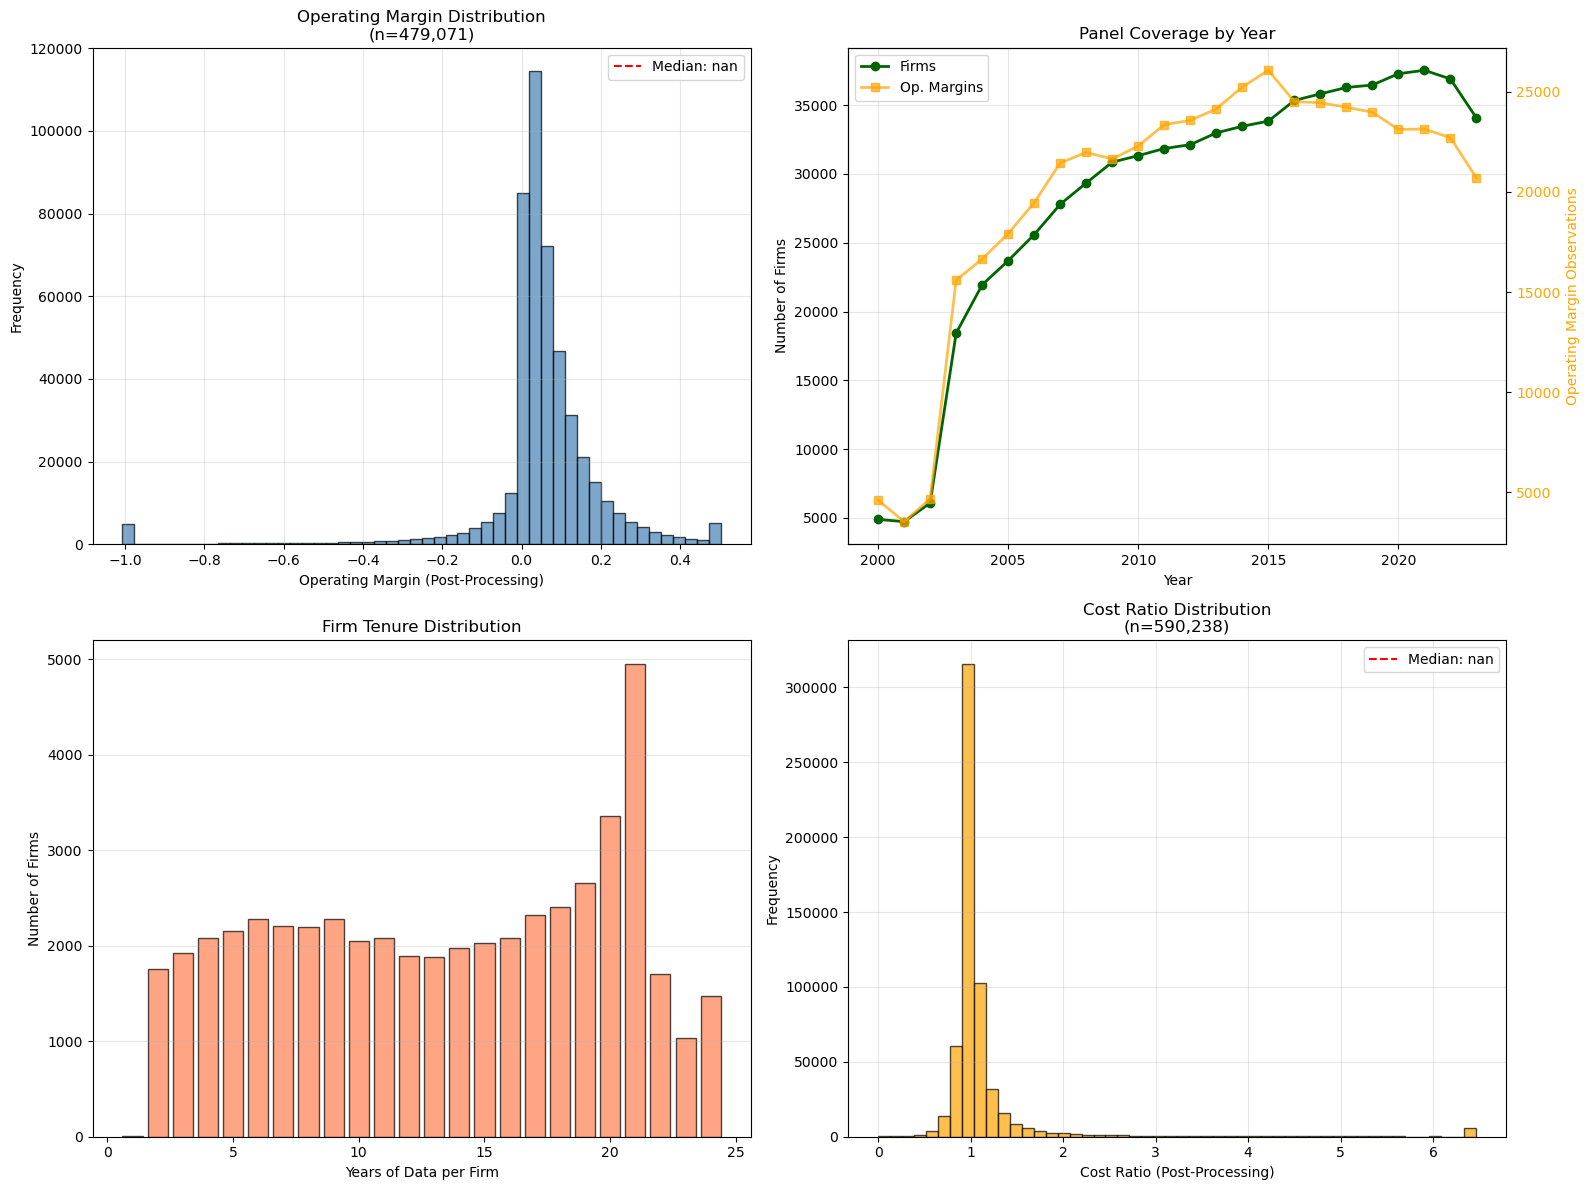

Saving final processed dataset...
Dataset saved to: ../data/source_cleaned/magnusweb_panel_imputed.parquet
   Final shape: (678576, 56)
   File size: 72.8 MB

Step 8 complete: Enrichment, visualization and export finished
Dataset saved to: ../data/source_cleaned/magnusweb_panel_imputed.parquet
   Final shape: (678576, 56)
   File size: 72.8 MB

Step 8 complete: Enrichment, visualization and export finished


In [22]:
print("\n" + "=" * 80)
print("STEP 8: NACE Enrichment, Visualization and Export")
print("=" * 80)

def enrich_with_nace(df: pl.DataFrame) -> pl.DataFrame:
    """Enrich the panel with NACE level 1 and level 2 codes."""
    print("🔧 Enriching panel with NACE level codes...")
    nace_matching_path = os.path.join("..", "data", "source_cleaned", "t_nace_matching.parquet")
    if not os.path.exists(nace_matching_path):
        print(f"   ⚠️ NACE matching file not found at {nace_matching_path}. Skipping.")
        return df

    nace_matching = pl.read_parquet(nace_matching_path)
    nace_for_join = nace_matching.select([
        "magnus_nace", "level1_code", "level2_code", "name_czso_en", "industry_flag"
    ]).unique(subset=["magnus_nace"])

    df_enriched = df.join(
        nace_for_join,
        left_on="main_nace_code",
        right_on="magnus_nace",
        how="left"
    )
    
    matched_count = df_enriched.filter(pl.col("level1_code").is_not_null()).shape[0]
    print(f"   ✅ Successfully matched {matched_count:,} rows ({matched_count/df.shape[0]*100:.1f}%)")
    return df_enriched

def create_data_quality_visualizations(df: pl.DataFrame, validation_results: Dict):
    """
    Create visualizations to document data quality and processing results.
    """
    print("Creating data quality visualizations...")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Operating margin distribution
    if "operating_margin_cal" in df.columns:
        op_margins = df.filter(pl.col("operating_margin_cal").is_not_null())["operating_margin_cal"].to_numpy()
        
        ax1.hist(op_margins, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        ax1.set_xlabel('Operating Margin (Post-Processing)')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'Operating Margin Distribution\n(n={len(op_margins):,})')
        ax1.grid(True, alpha=0.3)
        ax1.axvline(np.median(op_margins), color='red', linestyle='--', 
                   label=f'Median: {np.median(op_margins):.3f}')
        ax1.legend()
    
    # 2. Time series coverage
    coverage_by_year = (
        df.group_by("year")
        .agg([
            pl.col("ico").n_unique().alias("firms"),
            pl.col("operating_margin_cal").count().alias("op_margins"),
            pl.col("sales_revenue").count().alias("sales")
        ])
        .sort("year")
    )
    
    years = coverage_by_year["year"].to_numpy()
    firms = coverage_by_year["firms"].to_numpy()
    op_margins = coverage_by_year["op_margins"].to_numpy()
    
    ax2.plot(years, firms, marker='o', linewidth=2, label='Firms', color='darkgreen')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Number of Firms')
    ax2.set_title('Panel Coverage by Year')
    ax2.grid(True, alpha=0.3)
    
    # Secondary axis for ratio coverage
    ax2_twin = ax2.twinx()
    ax2_twin.plot(years, op_margins, marker='s', linewidth=2, label='Op. Margins', color='orange', alpha=0.7)
    ax2_twin.set_ylabel('Operating Margin Observations', color='orange')
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    
    # Combined legend
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 3. Firm tenure distribution - fixed syntax
    tenure_data = (
        df.group_by("ico")
        .agg(pl.col("year").count().alias("years"))
    )
    
    # Manual value counts
    tenure_dist = (
        tenure_data
        .group_by("years")
        .agg(pl.len().alias("count"))
        .sort("years")
    )
    
    if tenure_dist.shape[0] > 0:
        years_vals = tenure_dist["years"].to_numpy()
        counts = tenure_dist["count"].to_numpy()
        
        ax3.bar(years_vals, counts, alpha=0.7, color='coral', edgecolor='black')
        ax3.set_xlabel('Years of Data per Firm')
        ax3.set_ylabel('Number of Firms')
        ax3.set_title('Firm Tenure Distribution')
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Cost ratio distribution
    if "cost_ratio_cal" in df.columns:
        cost_ratios = df.filter(pl.col("cost_ratio_cal").is_not_null())["cost_ratio_cal"].to_numpy()
        
        ax4.hist(cost_ratios, bins=50, alpha=0.7, edgecolor='black', color='orange')
        ax4.set_xlabel('Cost Ratio (Post-Processing)')
        ax4.set_ylabel('Frequency')
        ax4.set_title(f'Cost Ratio Distribution\n(n={len(cost_ratios):,})')
        ax4.grid(True, alpha=0.3)
        ax4.axvline(np.median(cost_ratios), color='red', linestyle='--', 
                   label=f'Median: {np.median(cost_ratios):.3f}')
        ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

def save_final_dataset(df: pl.DataFrame, path: str, validation_results: Dict):
    """
    Save the final processed dataset with metadata.
    """
    print(f"Saving final processed dataset...")
    
    # Save the main dataset
    df.write_parquet(path, compression="snappy")
    
    print(f"Dataset saved to: {path}")
    print(f"   Final shape: {df.shape}")
    print(f"   File size: {os.path.getsize(path) / (1024**2):.1f} MB")
    
    # Create processing summary
    summary = {
        "processing_date": "2025-01-16",
        "input_file": input_path,
        "output_file": path,
        "processing_steps": [
            "Temporal filtering and firm viability checks",
            "Outlier detection using robust z-scores and YoY jumps",
            "Missing data analysis and selective imputation",
            "Economic logic filters and balance sheet consistency",
            "Ratio recalculation and winsorisation",
            "Final validation and quality assessment"
        ],
        "final_statistics": validation_results["structure"],
        "data_quality": validation_results["quality_flags"],
        "winsorisation_bounds": winsor_bounds
    }
    
    return summary

# Enrich with NACE codes
panel = enrich_with_nace(panel)

# Create visualizations
fig = create_data_quality_visualizations(panel, validation_results)

# Save final dataset
processing_summary = save_final_dataset(panel, output_path, validation_results)

print(f"\nStep 8 complete: Enrichment, visualization and export finished")

In [23]:
print("\n" + "=" * 80)
print("DATA PROCESSING SUMMARY")
print("=" * 80)

# Print comprehensive processing summary
print(f"\nProcessing completed successfully!")
print(f"\nFinal dataset statistics:")
print(f"   Input observations: {initial_shape[0]:,}")
print(f"   Final observations: {panel.shape[0]:,}")
print(f"   Retention rate: {panel.shape[0]/initial_shape[0]*100:.1f}%")
print(f"   Final firms: {panel['ico'].n_unique():,}")
print(f"   Average years per firm: {panel.shape[0]/panel['ico'].n_unique():.1f}")

print(f"\nProcessing steps applied:")
print(f"   Temporal filtering (lifecycle-based)")
print(f"   Economic logic filters")
print(f"   Outlier detection and treatment")
print(f"   Missing data analysis and selective imputation")
print(f"   Balance sheet consistency checks")
print(f"   Ratio recalculation and winsorisation")

print(f"\nData quality indicators:")
if 'validation_results' in globals():
    quality_flags = validation_results.get("quality_flags", {})
    print(f"   Low-data firms: {quality_flags.get('low_data_firms', 'N/A'):,}")
    
    # Print ratio statistics
    if "ratios" in validation_results:
        for ratio_name, stats in validation_results["ratios"].items():
            if stats:
                print(f"   {ratio_name}: {stats['count']:,} obs, median = {stats['median']:.4f}")

print(f"\nOutput file: {output_path}")
print(f"\nDataset ready for econometric analysis!")

# Store final metadata for reproducibility
final_metadata = {
    "processing_timestamp": "2025-01-16",
    "initial_observations": initial_shape[0],
    "final_observations": panel.shape[0],
    "retention_rate": panel.shape[0]/initial_shape[0],
    "unique_firms": panel['ico'].n_unique(),
    "time_span": f"{panel['year'].min()}-{panel['year'].max()}",
    "key_ratios_available": [col for col in RATIO_COLS if col in panel.columns],
    "processing_parameters": {
        "outlier_rz_threshold": OUTLIER_RZ_THRESHOLD,
        "yoy_jump_threshold": YOY_JUMP_THRESHOLD,
        "min_reporting_years": MIN_REPORTING_YEARS,
        "winsor_quantiles": (WINSOR_LOWER_Q, WINSOR_UPPER_Q),
        "max_balance_sheet_gap": MAX_BALANCE_SHEET_GAP
    }
}

print(f"\nProcessing metadata saved for reproducibility")


DATA PROCESSING SUMMARY

Processing completed successfully!

Final dataset statistics:
   Input observations: 1,754,304
   Final observations: 678,576
   Retention rate: 38.7%
   Final firms: 50,774
   Average years per firm: 13.4

Processing steps applied:
   Temporal filtering (lifecycle-based)
   Economic logic filters
   Outlier detection and treatment
   Missing data analysis and selective imputation
   Balance sheet consistency checks
   Ratio recalculation and winsorisation

Data quality indicators:
   Low-data firms: 7,870
   operating_margin_cal: 479,071 obs, median = 0.0462
   cost_ratio_cal: 590,238 obs, median = 1.0000
   net_margin_cal: 460,899 obs, median = 0.0324

Output file: ../data/source_cleaned/magnusweb_panel_imputed.parquet

Dataset ready for econometric analysis!

Processing metadata saved for reproducibility


In [24]:
# Final verification of the saved dataset
print("Final Dataset Verification:")
print("=" * 50)

# Load and verify the saved dataset
verification_panel = pl.read_parquet(output_path)
print(f"Saved dataset shape: {verification_panel.shape}")
print(f"File size: {os.path.getsize(output_path) / (1024**2):.1f} MB")

# Quick data quality check
print(f"\nQuick quality checks:")
print(f"   Unique firms: {verification_panel['ico'].n_unique():,}")
print(f"   Year range: {verification_panel['year'].min()}-{verification_panel['year'].max()}")
print(f"   Operating margin obs: {verification_panel['operating_margin_cal'].count():,}")
print(f"   Cost ratio obs: {verification_panel['cost_ratio_cal'].count():,}")

print(f"\nDataset successfully processed and saved!")
print(f"Ready for subsequent econometric analysis.")

Final Dataset Verification:
Saved dataset shape: (678576, 56)
File size: 72.8 MB

Quick quality checks:
   Unique firms: 50,774
   Year range: 2000-2023
   Operating margin obs: 479,071
   Cost ratio obs: 590,238

Dataset successfully processed and saved!
Ready for subsequent econometric analysis.
Saved dataset shape: (678576, 56)
File size: 72.8 MB

Quick quality checks:
   Unique firms: 50,774
   Year range: 2000-2023
   Operating margin obs: 479,071
   Cost ratio obs: 590,238

Dataset successfully processed and saved!
Ready for subsequent econometric analysis.
